##**IMPORT PYTHON LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
import warnings 
import sys
import pdb, os
import csv
import matplotlib.pyplot as plt
from scipy import misc
import scipy.ndimage as ndimage
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

## IMPORT CUSTOM LIBRARIES

In [ ]:
import DataLoad
from DataLoad import MyDataset
import modelCNN
from modelCNN import Conv_count
import Train


##**CHECK GPU AVAILABILITY**

In [ ]:
 
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
 
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


##CLONE THE DATASET

In [ ]:
!git clone https://github.com/ieee8023/countception.git

fatal: destination path 'countception' already exists and is not an empty directory.


##**CREATE CSV OF VGG IMAGE DATA**

In [ ]:
vgg_dataset_path = "countception/cells"
 
vgg_data_annotations = []
vgg_data_images = []
 
count = 0
for data_file in sorted(os.listdir(vgg_dataset_path)):
  if count % 2 != 0:
    vgg_data_annotations.append(vgg_dataset_path + '/' + str(data_file)) 
  if count % 2 == 0:
    vgg_data_images.append(vgg_dataset_path + '/' + str(data_file))
  count += 1
 
vgg_data = pd.DataFrame({'images' : vgg_data_images , 'annotations' : vgg_data_annotations})
vgg_data.head()

,images,annotations
0,countception/cells/001cell.png,countception/cells/001dots.png
1,countception/cells/002cell.png,countception/cells/002dots.png
2,countception/cells/003cell.png,countception/cells/003dots.png
3,countception/cells/004cell.png,countception/cells/004dots.png
4,countception/cells/005cell.png,countception/cells/005dots.png


In [ ]:
vgg_data = vgg_data.to_csv('vgg_data.csv', index = False)

**Split Train and Test of VGG Data**

In [ ]:
#Read the csv file
vgg = pd.read_csv('vgg_data.csv')
 
#Randomly shuffle the rows of the DataFrame
vgg = vgg.sample(frac = 1)
 
#split the DataFrame into two different DataFrmae with 80:20 ratio
vgg_train_valid, vgg_test = train_test_split(vgg, test_size=0.2)
 
#Convert DataFrame to csv file
vgg_train_valid = vgg_train_valid.to_csv('vgg_train_valid.csv', index = False)
 
#Convert DataFrame to csv file
vgg_test = vgg_test.to_csv('vgg_test.csv', index = False)

##**Data Visualization**

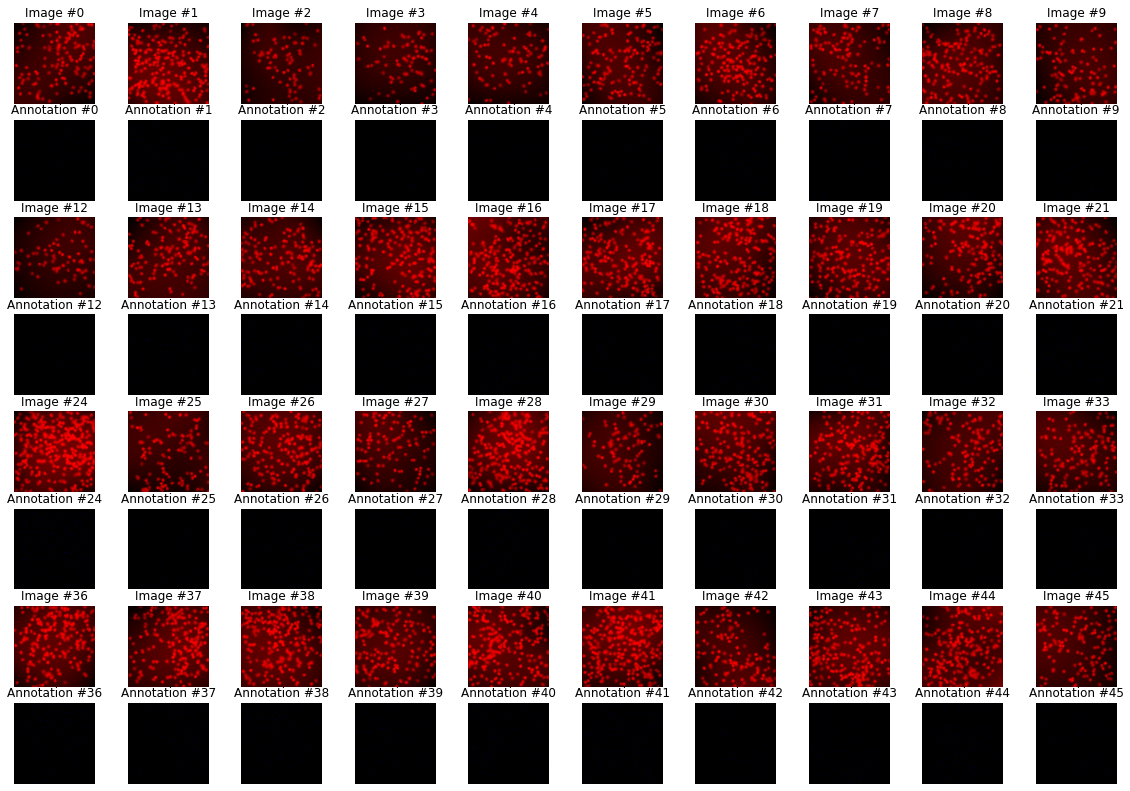

In [ ]:
# Illustrate the train images and masks
plt.figure(figsize=(20,14))
x, y = 10,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*12 + j*1
        plt.imshow(cv2.imread(vgg['images'][pos]))
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(cv2.imread(vgg['annotations'][pos]))
        plt.title('Annotation #{}'.format(pos))
        plt.axis('off')
        
plt.show()

**Clearly This kind of Visualization isn't good enough. That's why  Randomly chosen any Image and its Annotation are been visualized**

**Visualize Single VGG Cell Image & Annotation**

Image shape (256, 256, 3)
Annotation shape (256, 256, 3) 




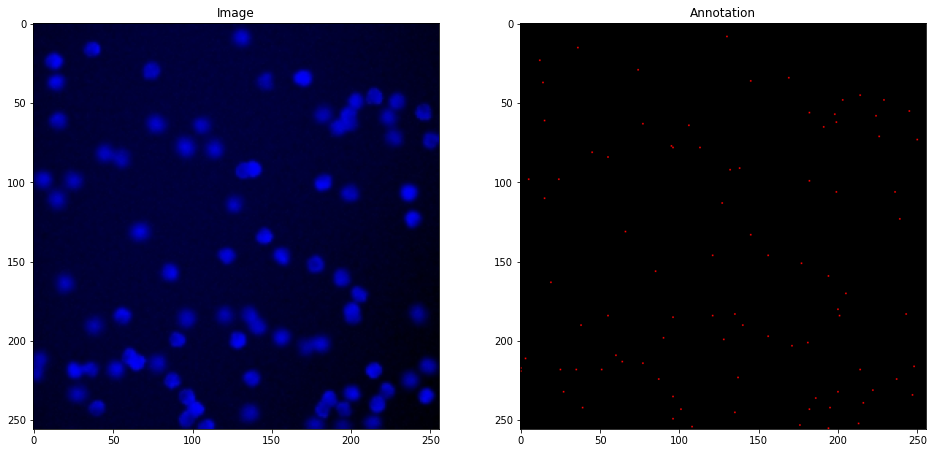

In [ ]:
id = np.random.randint(0,len(vgg)) # Generate RandomNumber
image_path, annotation_path = vgg['images'][id], vgg['annotations'][id] 
image_vgg = cv2.imread(image_path) # Read Image
annotation_vgg = cv2.imread(annotation_path) # Read Annotation

plt.figure(figsize=(16,26))

plt.subplot(1, 2, 1)
plt.imshow(image_vgg[:,:,::-1])
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(annotation_vgg[:,:,::-1])
plt.title('Annotation')

print('Image shape',image_vgg.shape)
print('Annotation shape',annotation_vgg.shape,'\n\n')

**Channel wise possible pixel Intensities of Annotation**

In [ ]:
print('Green Channel intensity values',set(annotation_vgg[:,:,0].flatten()))
print('Blue Channel intensity values',set(annotation_vgg[:,:,1].flatten()))
print('Red Channel intensity values',set(annotation_vgg[:,:,2].flatten()))

Green Channel intensity values {0}
Blue Channel intensity values {0}
Red Channel intensity values {0, 255}


**Randomly Cropped Image & annotation**

number of cells 3.0 



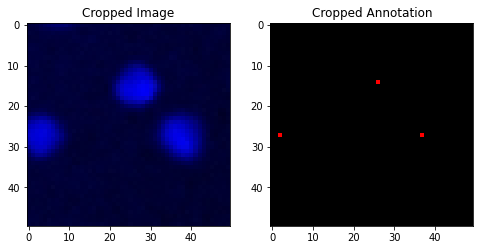

In [ ]:
position = np.random.randint(0,image_vgg.shape[0]-50) # a random number generated
random_crop_annot = annotation_vgg[position:position+50, position:position+50, :] # randomly cropped Annotation
random_crop_img = image_vgg[position:position+50, position:position+50, :] # Randomly Cropped Image

plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.imshow(random_crop_img[:,:,::-1])
plt.title('Cropped Image')

plt.subplot(1, 2, 2)
plt.imshow(random_crop_annot[:,:,::-1])
plt.title('Cropped Annotation')
print('number of cells',np.sum(random_crop_annot)/255,'\n')

**Intensity Visualization of Randomly Cropped Annotation**

Text(0, 0.5, 'Pixel Intensity')

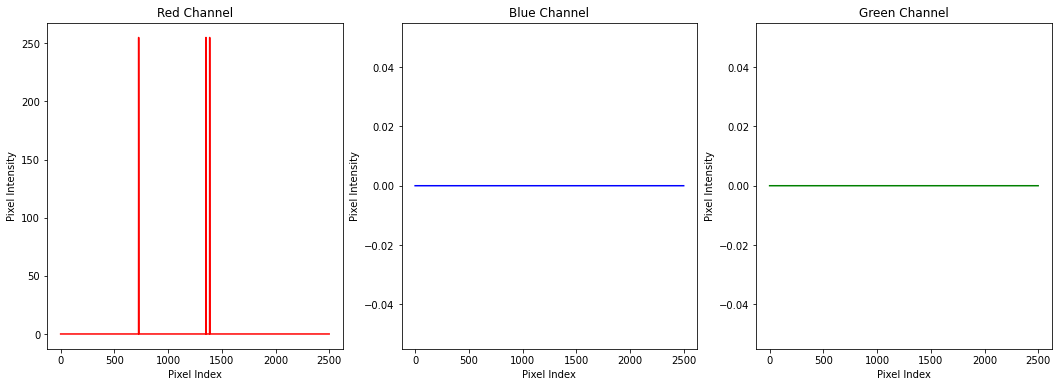

In [ ]:
red_channel_flatten = random_crop_annot[:,:,2].copy().flatten()
blue_channel_flatten = random_crop_annot[:,:,1].copy().flatten()
green_channel_flatten = random_crop_annot[:,:,0].copy().flatten()

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.plot(red_channel_flatten,color='red')
plt.title('Red Channel')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Intensity')

plt.subplot(1,3,2)
plt.plot(blue_channel_flatten, color='blue')
plt.title('Blue Channel')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Intensity')


plt.subplot(1,3,3)
plt.plot(green_channel_flatten, color='green')
plt.title('Green Channel')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Intensity')


##**Data Loading**

In [ ]:
vgg_train_data = MyDataset("vgg_train_valid.csv" )
vgg_test_data = MyDataset("vgg_test.csv", mode = 'test')

vgg_train_loader, vgg_valid_loader, vgg_test_loader = DataLoad.Data_Loader(vgg_train_data, vgg_test_data,batch_size=8)


##**Network Aechitechture**

In [ ]:
# initialize the NN
model = Conv_count()
print(model)

Conv_count(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)


##**Optimizer & Loss function**

In [ ]:
# specify loss function
criterion = nn.L1Loss()
 
# specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, nesterov=True)

##**Training and Validation**

In [ ]:
train_loss_list, validation_loss_list, model = Train.model_train(300,model, vgg_train_loader, vgg_valid_loader, criterion, optimizer)

Epoch: 1 	Training Loss: 6.927914 	Validation Loss: 7.934538
Validation loss decreased (inf --> 7.934538).  Saving model ...
Epoch: 2 	Training Loss: 6.916678 	Validation Loss: 7.909887
Validation loss decreased (7.934538 --> 7.909887).  Saving model ...
Epoch: 3 	Training Loss: 6.904051 	Validation Loss: 7.888464
Validation loss decreased (7.909887 --> 7.888464).  Saving model ...
Epoch: 4 	Training Loss: 6.892885 	Validation Loss: 7.868416
Validation loss decreased (7.888464 --> 7.868416).  Saving model ...
Epoch: 5 	Training Loss: 6.881843 	Validation Loss: 7.849054
Validation loss decreased (7.868416 --> 7.849054).  Saving model ...
Epoch: 6 	Training Loss: 6.871770 	Validation Loss: 7.829212
Validation loss decreased (7.849054 --> 7.829212).  Saving model ...
Epoch: 7 	Training Loss: 6.860631 	Validation Loss: 7.810925
Validation loss decreased (7.829212 --> 7.810925).  Saving model ...
Epoch: 8 	Training Loss: 6.849677 	Validation Loss: 7.793458
Validation loss decreased (7.81092

##**Visualize Training and Validation Loss**

Text(0.5, 1.0, 'Visualize Training and Validation Loss')

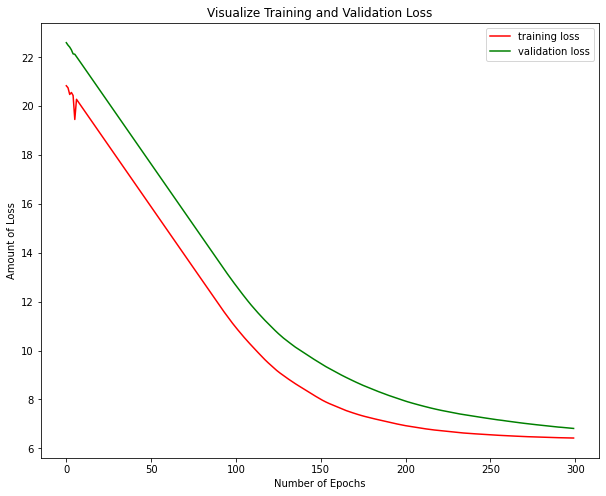

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_loss_list,color='red' ,label='training loss')
plt.plot(validation_loss_list,color='green' ,label = 'validation loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Amount of Loss')
plt.title('Visualize Training and Validation Loss')

## Model Testing 

In [ ]:
######################    
  # test the model #
######################
test_loss = []
target_list = []
prediction_list = []
 
test_loader = vgg_test_loader 
for idx, (input, target_count) in enumerate(test_loader):
    
    output = model(input)
    loss = criterion(output, target_count)
    test_loss.append(loss.item())
    target_list.append(target_count.detach().numpy()[0])
    prediction_list.append(np.round(np.squeeze(output.detach().numpy())))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


##Visualize Test Loss

Text(0.5, 1.0, 'Visualize Test Loss')

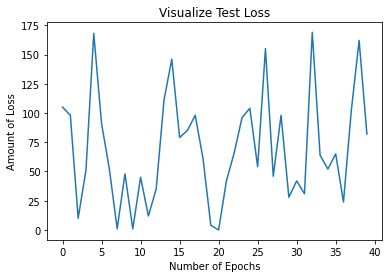

In [ ]:
plt.plot(test_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Amount of Loss')
plt.title('Visualize Test Loss')

## Comparisn of Prediction & Target

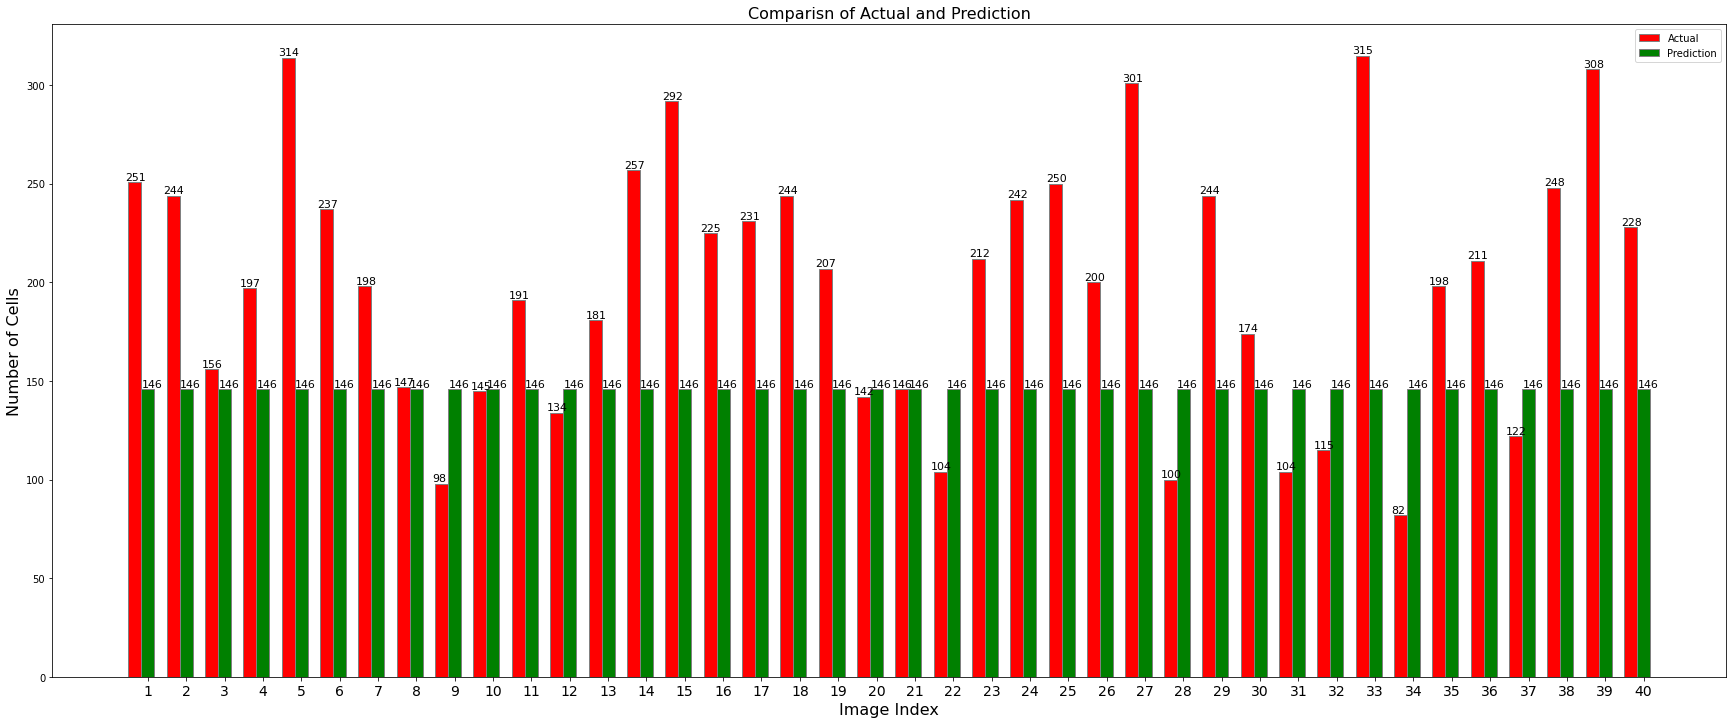

In [ ]:
barWidth = 0.95
plt.figure(figsize=(30,12))

plt.bar(np.array(range(len(target_list)))*2.8, target_list, color ='r', width = barWidth,
        edgecolor ='grey', label ='Actual')

for index,data in enumerate(target_list):
    plt.text(x=index*2.8 - 0.7, y =data+1 , s=f"{int(data)}" , fontdict=dict(fontsize=11))


plt.bar(np.array(range(len(prediction_list)))*2.8 +barWidth, prediction_list, color ='g', width = barWidth,
        edgecolor ='grey', label ='Prediction')

for index,data in enumerate(prediction_list):
    plt.text(x=index*2.8 + 0.5 , y =data+1 , s=f"{int(data)}" , fontdict=dict(fontsize=11))


plt.legend()

plt.xticks([r*2.8 + barWidth for r in range(len(target_list))],
        [str(x) for x in range(1,len(target_list)+1)],fontsize=14)

plt.xlabel('Image Index',fontsize=16)
plt.ylabel('Number of Cells',fontsize=16)
plt.title('Comparisn of Actual and Prediction',fontsize=16)

plt.show()

##Comparisn of Prediction & Target(2nd Visualization)

Text(0.5, 1.0, 'Comparisn of Actual and Prediction')

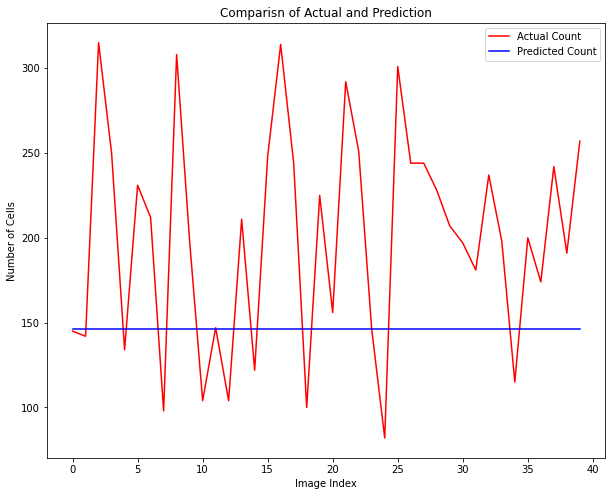

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(target_list,color='red' ,label='Actual Count')
plt.plot(prediction_list,color='blue' ,label='Predicted Count')
plt.legend()
plt.xlabel('Image Index')
plt.ylabel('Number of Cells')
plt.title('Comparisn of Actual and Prediction')

## Target and Prediction In Table Format

In [ ]:
test_dict = pd.DataFrame({'target': target_list, 'prediction': prediction_list})
test_dict


,target,prediction
0,145.0,146.0
1,142.0,146.0
2,315.0,146.0
3,250.0,146.0
4,134.0,146.0
5,231.0,146.0
6,212.0,146.0
7,98.0,146.0
8,308.0,146.0
9,198.0,146.0


## Measurement of Model Performance

In [ ]:
difference_list = abs(np.array(target_list) - np.array(prediction_list))
ratio = np.sum(difference_list) / np.sum(target_list)
accuracy = (1 - ratio)*100
print('Model Performence is',np.round(accuracy,2),'%')

Model Performence is 65.19 %
